In [15]:
import pynapple as nap
import numpy as np
import matplotlib.pyplot as plt

import os
from os.path import dirname, join as pjoin
import scipy.io as sio

import pymatreader

In [17]:
data_dir = pjoin('C:\\Users\\Acer\\Documents\\compNeuroProjects\\neural_reco_offline\\Duszkiewicz2024', 'Dataset_2', 'A3701-191119', 'Data')
spikeData_fname = pjoin(data_dir, 'SpikeData.mat')

In [16]:
os.listdir(data_dir)

['._Ahv.mat',
 '._Angle.mat',
 '._BehavEpochs.mat',
 '._BrainArea.mat',
 '._CellDepth.mat',
 '._CellTypes.mat',
 '._Epoch_TS.csv',
 '._SpikeData.mat',
 '._Tracking_data.csv',
 '._Velocity.mat',
 '._WaveformFeatures.mat',
 '._Waveforms.mat',
 'Ahv.mat',
 'Angle.mat',
 'BehavEpochs.mat',
 'BrainArea.mat',
 'CellDepth.mat',
 'CellTypes.mat',
 'Epoch_TS.csv',
 'SpikeData.mat',
 'Tracking_data.csv',
 'Velocity.mat',
 'WaveformFeatures.mat',
 'Waveforms.mat']

In [18]:
spikeData = pymatreader.read_mat(spikeData_fname)
spikeData.keys()

dict_keys(['__header__', '__version__', '__globals__', 'S', 'S_Info', 'shank', 'shank_Info', 'cellIx', 'cellIx_Info'])

In [19]:
sp_times = spikeData["S"]['C'][0]['tsd']['t']

(2000.0, 2010.0)

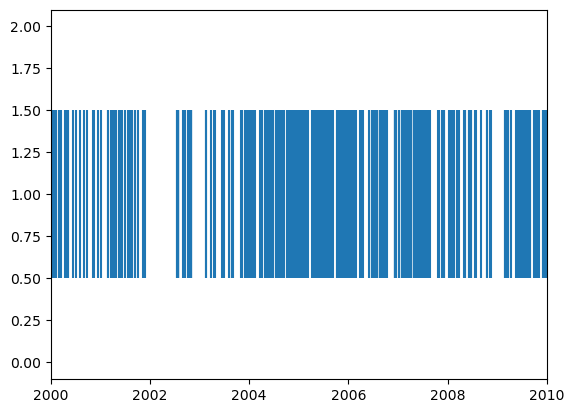

In [14]:
plt.eventplot(sp_times)
ax = plt.gca()
ax.set_xlim([2000,2010])